In [48]:
from datasets import load_dataset
import pandas as pd
import random
import math
import seaborn as sns
from tqdm import tqdm
from collections import Counter

In [3]:
dataset = load_dataset("refugee-law-lab/canadian-legal-data", "SCC", split="train")

# convert to dataframe
df = pd.DataFrame(dataset)

In [5]:
# isolate for english decisions
df = df[df['language'] == 'en']

# convert document date to datetime
df['document_date'] = pd.to_datetime(df['document_date'])
df['year'] = df['document_date'].dt.year

/var/folders/54/pnyqyxcd4013kndyzbprlnxh0000gn/T/ipykernel_81826/2257051110.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['document_date'] = pd.to_datetime(df['document_date'])
/var/folders/54/pnyqyxcd4013kndyzbprlnxh0000gn/T/ipykernel_81826/2257051110.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['document_date'].dt.year


In [ ]:
def preprocess_text(text):
    result = ""
    for char in text:
        if char.isalpha() or char == " ":
            result += char
    
    return result

df['cleaned'] = df['unofficial_text'].apply(preprocess_text)
df['cleaned'] = df['cleaned'].str.lower()

/var/folders/54/pnyqyxcd4013kndyzbprlnxh0000gn/T/ipykernel_81826/3519600333.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned'] = df['unofficial_text'].apply(preprocess_text)


In [11]:
# concat all the text by year
years = df.groupby('year').agg({'cleaned': ' '.join}).reset_index()

In [13]:
def word_count(text):
    return len(text.split())

years['word_count'] = years['cleaned'].apply(word_count)

<Axes: title={'center': 'Word Count of SCC Decisions by Year'}>

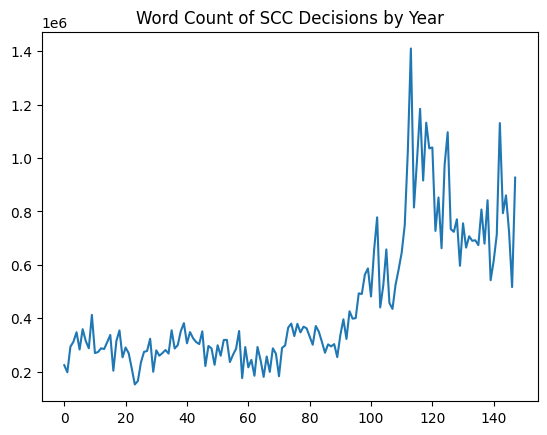

In [14]:
years['word_count'].plot(kind='line', x='year', y='word_count', title='Word Count of SCC Decisions by Year')

In [71]:
def shannon_entropy(tokens):
    entropy = 0
    num_tokens = len(tokens)
    frequencies = Counter(tokens)
    
    for token, count in frequencies.items():
        p = count / num_tokens
        entropy += p * math.log2(p)
    
    return -entropy

def sample_text(text, n=100000, window=500):
    tokens = text.split()
    num_tokens = len(tokens)
    entropies = []
    for i in range(n):
        idx = random.randint(0, num_tokens-window)
        entropies.append(shannon_entropy(tokens[idx:idx+window]))
    return entropies


In [72]:
res = sample_text(years.loc[3, 'cleaned'])

<Axes: ylabel='Count'>

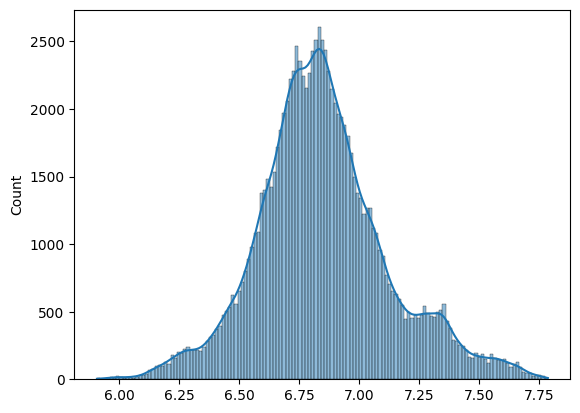

In [73]:
sns.histplot(res, kde=True)

In [74]:
tqdm.pandas(desc="Processing")
entropies = years['cleaned'].progress_apply(sample_text)

Processing: 100%|██████████| 148/148 [09:11<00:00,  3.72s/it]


In [75]:
ent_df = pd.DataFrame(entropies.tolist())
ent_df['year'] = years['year']
ent_df.set_index('year', inplace=True)
ent_df

,0,1,2,3,4,5,6,7,8,9,...,99990,99991,99992,99993,99994,99995,99996,99997,99998,99999
year,,,,,,,,,,,,,,,,,,,,,
1877,6.566589,7.029846,7.347878,6.739783,6.993483,6.998287,7.329852,6.808645,6.954032,6.673308,...,7.023259,6.885695,6.777747,7.016557,6.756899,7.527052,7.398738,6.991401,7.522918,6.908529
1878,6.635788,7.117918,6.863327,6.579747,7.050530,7.013264,6.798362,6.888341,6.650723,6.890929,...,6.907344,6.680008,6.643148,6.405938,6.771518,7.031550,6.833400,6.988451,7.481602,6.438688
1879,6.586916,6.931530,7.041978,6.698061,7.271282,6.946769,7.641677,7.184019,6.833643,6.487341,...,6.495779,7.223991,6.717143,6.589780,7.154039,6.996357,6.686649,6.878560,6.853627,6.666086
1880,6.600811,6.808936,6.963249,6.469638,6.879277,6.766659,6.517928,6.784355,7.042805,6.466890,...,6.934963,6.511624,7.204123,6.856666,7.025294,6.663471,6.768290,7.044519,6.725271,6.893739
1881,6.752343,6.502295,6.567653,6.796240,6.772660,6.604050,6.762673,6.761266,6.911106,6.539202,...,7.220153,7.249859,6.362170,6.535316,6.663144,6.387818,6.473413,7.040574,6.857091,6.874890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020,7.148698,7.069580,7.006393,6.569787,6.847120,6.943836,7.108160,7.158424,6.707922,6.863590,...,7.039651,7.334446,6.817515,7.115959,6.717974,6.986673,7.026016,6.926747,7.019375,6.830334
2021,6.673142,6.917501,6.815607,6.936108,6.438338,7.265268,6.391066,7.036535,7.046525,6.492978,...,6.900561,6.913759,6.904144,7.034929,7.000810,7.010538,6.758324,6.959428,6.977216,7.230267
2022,7.231807,6.915564,7.076895,6.976303,7.259846,6.341246,7.122547,7.174824,7.462268,6.939241,...,7.020448,7.114481,6.977857,7.193113,7.169103,7.146842,7.210561,6.496259,7.099848,6.724903


<Axes: xlabel='2023', ylabel='Count'>

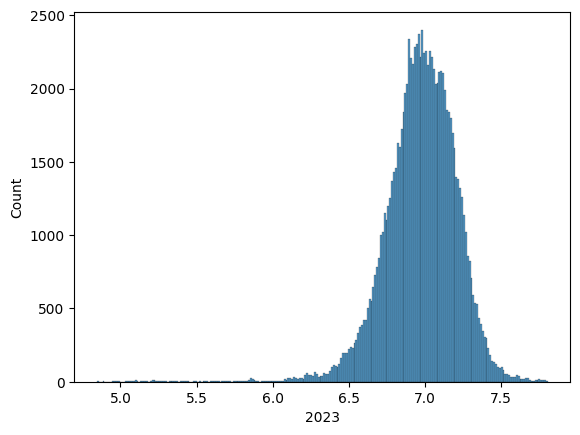

In [76]:
sns.histplot(ent_df.loc[2023])

<Axes: title={'center': 'Shannon Entropy of SCC Decisions by Year'}, xlabel='year'>

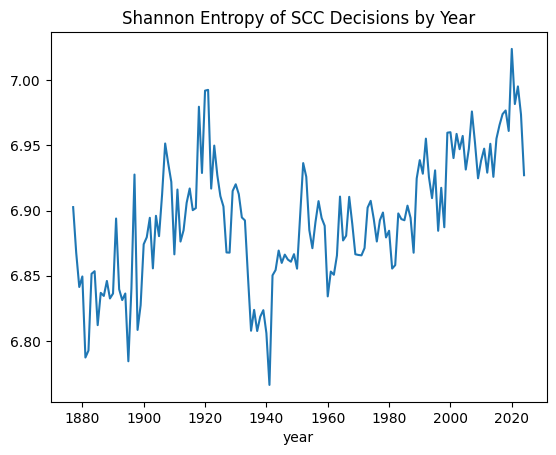

In [77]:
ent_df.mean(axis=1).plot(kind='line', x='year', y='entropy', title='Shannon Entropy of SCC Decisions by Year')

<Axes: title={'center': 'Shannon Entropy of SCC Decisions by Year'}, xlabel='year'>

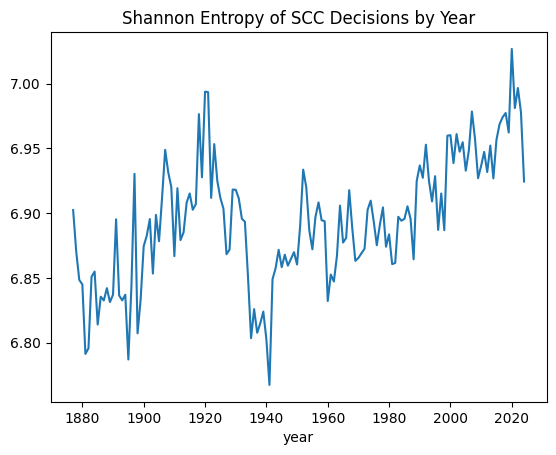

In [68]:
ent_df.mean(axis=1).plot(kind='line', x='year', y='entropy', title='Shannon Entropy of SCC Decisions by Year')

<Axes: title={'center': 'Shannon Entropy of SCC Decisions by Year'}, xlabel='year'>

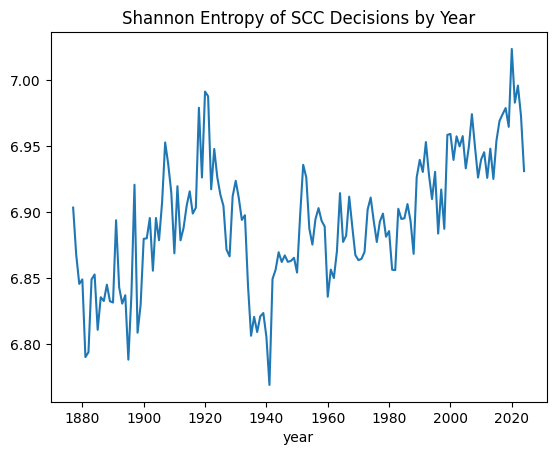

In [81]:
# sample 10% of columns
ent_df.sample(frac=0.1, axis=1).mean(axis=1).plot(kind='line', x='year', y='entropy', title='Shannon Entropy of SCC Decisions by Year')

<Axes: xlabel='year'>

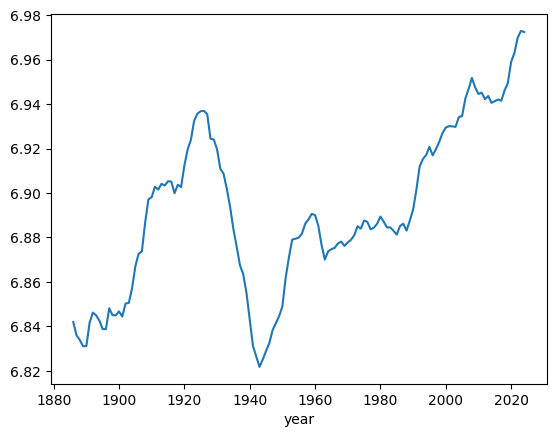

In [90]:
ent_df.sample(frac=0.01, axis=1).mean(axis=1).rolling(10).mean().plot()

Bottom line:

It looks like there are four periods of interest in Canadian law. From the Court's founding to the 1920s, entropy steadily increased. From the 1920s to the Second World War it decreased. From the War to 1960 it increased. Then stabilized to the mid 1980s. Then steadily increased.

How significant is this? That's a good question.

Some back of the napkin math.

low of 6.82 to a high of 6.98.

That's a 2.3% increase.

so 2 bits to the power of 6.82 is: 112.9

2 to the power of 6.98 is: 126.2

so, effective vocab has increased 11.7%.

I welcome feedback: simon.wallace@torontomu.ca

In [115]:
(126.2/112.9) -1

0.11780336581045159